# SAR Nonlinear Discriminant Function Analysis

## Spatially Adjusted Regression - Two Group Discriminant Function Analysis

Logistic Regression vs Logistic Regression with Eigenvector Spatial Filter

It is assumed that we are working with a non-linear, non-normal probability model. The goals are to: 


a) evaluate a standard non-linear, binomial logistic regression using a binary response variable (2 groups) when spatial autocorrelation is thought to be present and 

b)evaluate the same relationships given the ability to adjust for spatial autocorrelation using a binomial logistic regression coupled with an eigenvector spatial filter.

In [3]:
# Load relevant R packages
inLibraries = list('rgdal','spdep','classInt','car','RColorBrewer','MASS')
for (rpack in inLibraries) {
  if (is.element(rpack,installed.packages()[,1])){           
      #Load the library into R
      suppressMessages(library(rpack,character.only = TRUE))
    }
    else {
        print(paste("Warning:  ",rpack," is not an installed package"))
    }
}
#resize plot area
options(repr.plot.width=6, repr.plot.height=6)

## US Farming Data

In this exercise, we will be working with county data on agricultural practices in the USA (usagriculture/usfarming.shp). Elements of this dataset were obtained from the 2012 US ag. census: https://www.agcensus.usda.gov/Publications/2012/Online_Resources/Ag_Census_Web_Maps/Data_download/index.php. The fields in this dataset may seem kinda mystical, but they are documented in depth at the website noted above (download the associated excel and/or pdf file).

While the Agriculture Census data is great for agricultural info, there is also some county level US Census data that we'd like to use that contains better detail about the human population associated with US counties.  The US Census county-level polygon data can be found at (us_counties/UScounties.shp).

Read in the Ag. Census and US Census county featureclasses.

In [4]:
ag <- readOGR("/dsa/data/geospatial/DS8612/usagriculture","usfarming")

OGR data source with driver: ESRI Shapefile 
Source: "/dsa/data/geospatial/DS8612/usagriculture", layer: "usfarming"
with 3070 features
It has 93 fields


In [5]:
census <- readOGR("/dsa/data/geospatial/DS8612/us_counties", "UScounties")

OGR data source with driver: ESRI Shapefile 
Source: "/dsa/data/geospatial/DS8612/us_counties", layer: "UScounties"
with 3109 features
It has 22 fields


In [6]:
head(ag@data)

,Join_Count,TARGET_FID,atlas_stco,atlas_name,atlas_caps,atlas_area,atlas_acre,entity,cntya,cntyn,⋯,y12_M264_v,y12_M264_c,y12_M264_1,y12_M265_v,y12_M265_c,y12_M265_1,y12_M266_v,y12_M266_c,y12_M266_1,coastal
0,1,0,01001,Autauga,AUTAUGA,594.437,380439.7,County,001,1,⋯,2.37,Sparse Data,2.37,0.09,Less than 1,0.09,2.96,1 - 2,2.96,NA
1,2,1,01003,Baldwin,BALDWIN,1589.840,1017497.6,County,003,3,⋯,0.63,Sparse Data,0.63,0.04,Less than 1,0.04,4.09,3 - 5,4.09,1
2,2,2,01005,Barbour,BARBOUR,884.876,566320.6,County,005,5,⋯,0.03,Sparse Data,0.03,0.00,Less than 1,0.00,7.68,6 - 8,7.68,NA
3,1,3,01007,Bibb,BIBB,622.583,398453.1,County,007,7,⋯,2.01,Sparse Data,2.01,0.00,Less than 1,0.00,0.86,Less than 1,0.86,NA
4,1,4,01009,Blount,BLOUNT,644.807,412676.5,County,009,9,⋯,-0.21,Sparse Data,-0.21,(D),Less than 1,0.00,0.90,Less than 1,0.90,NA
5,2,5,01011,Bullock,BULLOCK,622.805,398595.2,County,011,11,⋯,1.43,Sparse Data,1.43,(D),Less than 1,0.00,7.24,6 - 8,7.24,NA


In [7]:
head(census@data)

,OBJECTID,ID,NAME,STATE_NAME,ST_ABBREV,AREA,TOTPOP00,FAMPOP00,RURALFARM,FAMHH00,⋯,FEMALES00,WHITE00,BLACK00,AGGHOMEVAL,POP2000,HOUSEHOLDS,HSE_UNITS,BUS_COUNT,Genshp_Len,Genshp_Are
0,8,24011,Caroline,Maryland,MD,324.2379,29772,24729,1105,8156,⋯,15201,24322,4398,432584500,29772,11097,12028,1074,162047.1,843500156
1,9,24019,Dorchester,Maryland,MD,573.7993,30674,24353,604,8506,⋯,16164,21302,8708,522579000,30674,12706,14681,1290,607925.7,1485189115
2,10,24039,Somerset,Maryland,MD,331.3127,24747,15917,595,5444,⋯,11534,13949,10172,250004000,24747,8361,10092,656,544390.0,847349487
3,11,24041,Talbot,Maryland,MD,273.1406,33812,27124,836,9630,⋯,17687,27720,5193,1219575500,33812,14307,16500,2266,550406.2,690248455
4,12,53009,Clallam,Washington,WA,1764.3180,64525,50317,410,18068,⋯,32471,57505,545,1039164500,64525,27164,30683,3271,428520.9,4583464777
5,13,53027,Grays Harbor,Washington,WA,1929.1432,67194,53306,606,17914,⋯,33804,59335,226,696861000,67194,26808,32489,2820,450185.9,5004579109


Select only Ag. Census and US Census counties in the state of North Carolina. 

In [8]:
# FIP Code for North Carolina = 37
# According to https://www.mcc.co.mercer.pa.us/dps/state_fips_code_listing.htm

# subset the atlast_stco column first to obtain the first 2 digits
ag@data$stcode <- substr(ag@data$atlas_stco, start = 1, stop = 2)
head(ag@data$stcode)

[1] "01" "01" "01" "01" "01" "01"

In [9]:
ag_nc <- ag[grep("37", ag@data$stcode), ]
paste(length(ag_nc), "polygons for North Carolina Ag")

[1] "100 polygons for North Carolina Ag"

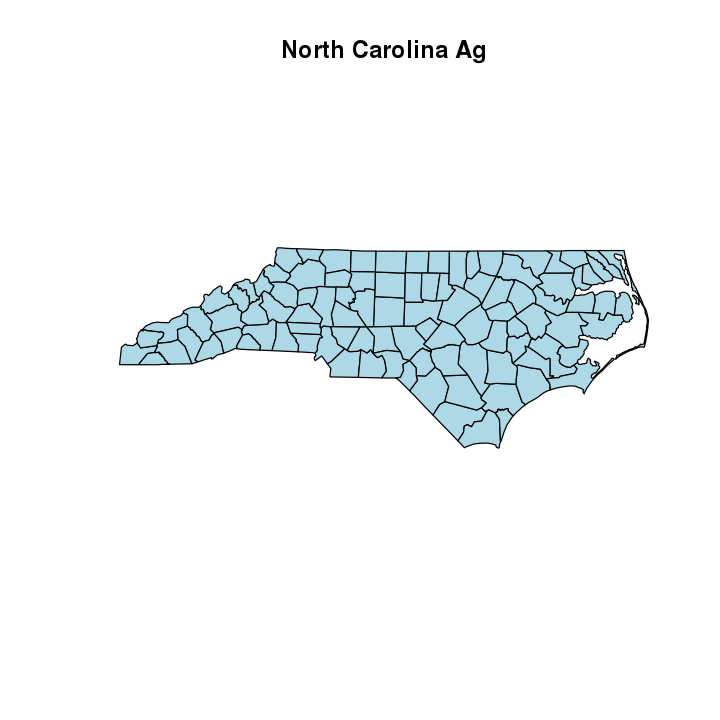

In [10]:
plot(ag_nc, col = "lightblue", main = "North Carolina Ag")

In [11]:
census_nc <- census[grep("North Carolina", census@data$STATE_NAME), ]
paste(length(census_nc), "polygons for North Carolina Census")

[1] "100 polygons for North Carolina Census"

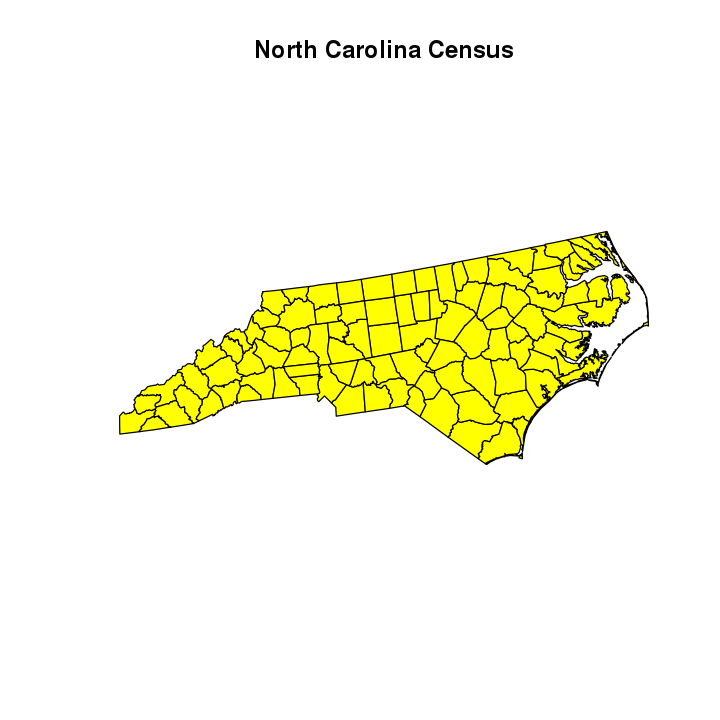

In [12]:
plot(census_nc, col = "yellow", main = "North Carolina Census")

Join the selected US Census data to the selected Ag. Census data. This can be an attribute join by FIPs code.

In [13]:
# let's make sure their CRS are aligned properly.

proj4string(ag_nc)

[1] "+proj=longlat +datum=NAD83 +no_defs +ellps=GRS80 +towgs84=0,0,0"

In [14]:
proj4string(census_nc)

[1] "+proj=aea +lat_1=29.5 +lat_2=45.5 +lat_0=23 +lon_0=-96 +x_0=0 +y_0=0 +datum=NAD83 +units=m +no_defs +ellps=GRS80 +towgs84=0,0,0"

In [15]:
# Not aligned. I'm going to project census_nc to ag_nc's CRS

census_nc_proj <- spTransform(census_nc, CRS("+proj=longlat +datum=NAD83 +no_defs +ellps=GRS80 +towgs84=0,0,0"))

proj4string(census_nc_proj)

[1] "+proj=longlat +datum=NAD83 +no_defs +ellps=GRS80 +towgs84=0,0,0"

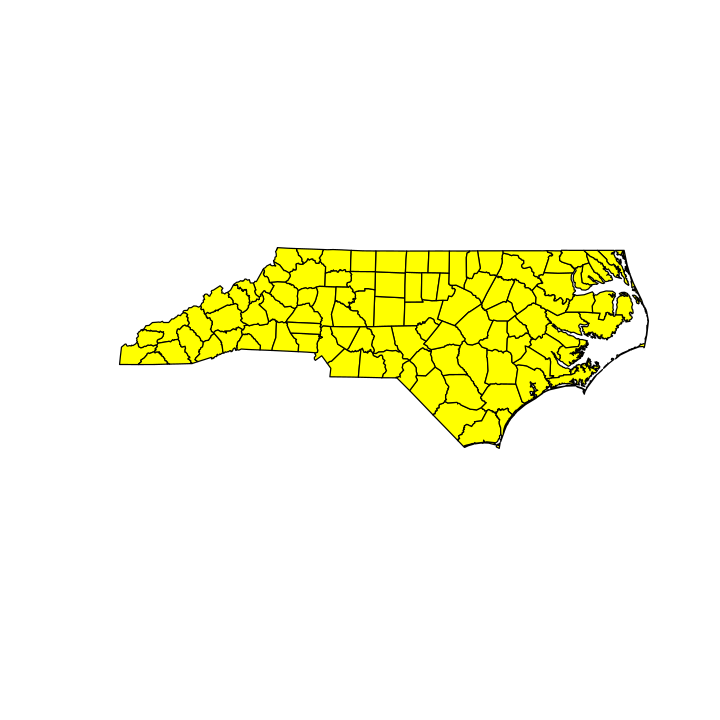

In [16]:
plot(census_nc_proj, col = "yellow")

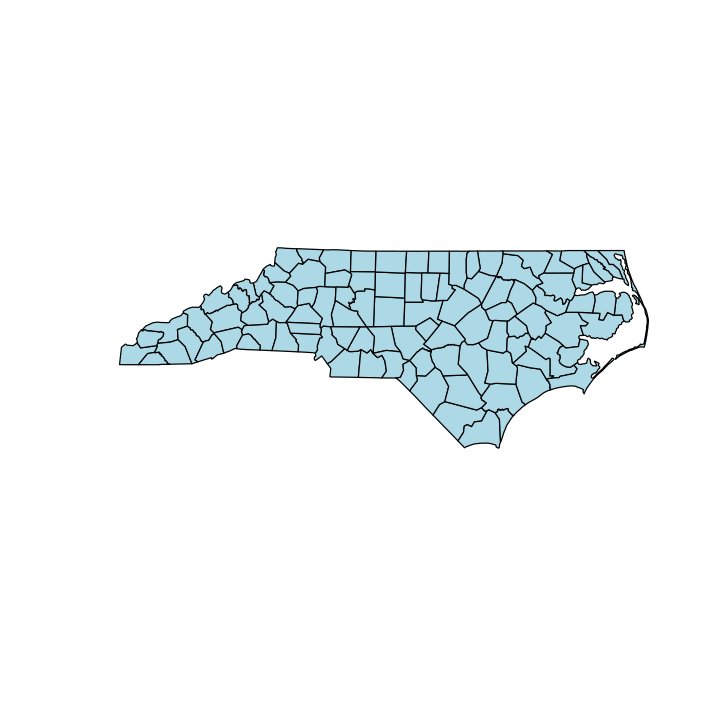

In [17]:
plot(ag_nc, col = "lightblue")

In [18]:
head(census_nc_proj@data)

,OBJECTID,ID,NAME,STATE_NAME,ST_ABBREV,AREA,TOTPOP00,FAMPOP00,RURALFARM,FAMHH00,⋯,FEMALES00,WHITE00,BLACK00,AGGHOMEVAL,POP2000,HOUSEHOLDS,HSE_UNITS,BUS_COUNT,Genshp_Len,Genshp_Are
1437,1470,37087,Haywood,North Carolina,NC,554.6455,54033,44244,843,16043,⋯,28136,52330,684,681258500,54033,23100,28640,2241,182364.9,1437400225
1438,1471,37115,Madison,North Carolina,NC,451.5772,19635,15697,1273,5595,⋯,9951,19169,162,100860500,19635,8000,9722,440,175539.4,1166862824
2504,2537,37005,Alleghany,North Carolina,NC,235.5009,10677,8711,640,3169,⋯,5418,10217,131,101775000,10677,4593,6412,554,127220.6,607837195
2505,2538,37009,Ashe,North Carolina,NC,426.7859,24384,20421,1038,7422,⋯,12353,23691,162,244242500,24384,10411,13268,1173,147323.8,1108049436
2553,2586,37039,Cherokee,North Carolina,NC,466.5996,24298,20373,312,7373,⋯,12512,23040,387,208654500,24298,10336,13499,1213,171400.5,1209054257
2554,2587,37043,Clay,North Carolina,NC,220.5807,8775,7320,206,2727,⋯,4503,8600,70,92466500,8775,3847,5425,457,125013.7,567595296


In [19]:
head(ag_nc@data)

,Join_Count,TARGET_FID,atlas_stco,atlas_name,atlas_caps,atlas_area,atlas_acre,entity,cntya,cntyn,⋯,y12_M264_c,y12_M264_1,y12_M265_v,y12_M265_c,y12_M265_1,y12_M266_v,y12_M266_c,y12_M266_1,coastal,stcode
1853,1,1853,37001,Alamance,ALAMANCE,423.828,271249.9,County,001,1,⋯,Sparse Data,0.03,0.00,Less than 1,0.00,0.24,Less than 1,0.24,NA,37
1854,3,1854,37003,Alexander,ALEXANDER,259.956,166371.8,County,003,3,⋯,Sparse Data,1.68,0.00,Less than 1,0.00,0.27,Less than 1,0.27,NA,37
1855,2,1855,37005,Alleghany,ALLEGHANY,235.060,150438.4,County,005,5,⋯,Sparse Data,3.13,0.01,Less than 1,0.01,(D),Less than 1,0.00,NA,37
1856,1,1856,37007,Anson,ANSON,531.451,340128.6,County,007,7,⋯,Sparse Data,2.06,(D),Less than 1,0.00,7.49,6 - 8,7.49,NA,37
1857,2,1857,37009,Ashe,ASHE,426.151,272736.6,County,009,9,⋯,Sparse Data,1.00,0.05,Less than 1,0.05,(D),Less than 1,0.00,NA,37
1858,3,1858,37011,Avery,AVERY,247.088,158136.3,County,011,11,⋯,Sparse Data,-0.58,0.00,Less than 1,0.00,0.00,Less than 1,0.00,NA,37


In [20]:
joined <- merge(x = census_nc_proj, y = ag_nc@data, 
                   by.x = "ID", by.y = "atlas_stco", 
                   all = TRUE)

dim(joined)

Warning message in merge.data.frame(x@data, y, by = by, by.x = by.x, by.y = by.y, :
“column name ‘ID’ is duplicated in the result”

[1] 100 115

In [21]:
head(joined@data)

,ID,OBJECTID,NAME,STATE_NAME,ST_ABBREV,AREA,TOTPOP00,FAMPOP00,RURALFARM,FAMHH00,⋯,y12_M264_c,y12_M264_1,y12_M265_v,y12_M265_c,y12_M265_1,y12_M266_v,y12_M266_c,y12_M266_1,coastal,stcode
44,37087,1470,Haywood,North Carolina,NC,554.6455,54033,44244,843,16043,⋯,Sparse Data,-1.15,0.00,Less than 1,0.00,0.04,Less than 1,0.04,NA,37
58,37115,1471,Madison,North Carolina,NC,451.5772,19635,15697,1273,5595,⋯,Sparse Data,-4.47,0.00,Less than 1,0.00,0.15,Less than 1,0.15,NA,37
3,37005,2537,Alleghany,North Carolina,NC,235.5009,10677,8711,640,3169,⋯,Sparse Data,3.13,0.01,Less than 1,0.01,(D),Less than 1,0.00,NA,37
5,37009,2538,Ashe,North Carolina,NC,426.7859,24384,20421,1038,7422,⋯,Sparse Data,1.00,0.05,Less than 1,0.05,(D),Less than 1,0.00,NA,37
20,37039,2586,Cherokee,North Carolina,NC,466.5996,24298,20373,312,7373,⋯,Sparse Data,4.06,(D),Less than 1,0.00,0.39,Less than 1,0.39,NA,37
22,37043,2587,Clay,North Carolina,NC,220.5807,8775,7320,206,2727,⋯,Sparse Data,4.41,0.00,Less than 1,0.00,(D),Less than 1,0.00,NA,37


Generate neighborhoods for each feature according to the Queen's Criterion.  Then test the neighborhoods to see if they are valid.  Retain only the features with valid neighborhoods.

In [22]:
joined.nb <- poly2nb(joined, queen = TRUE)

In [23]:
head(joined.nb)

[[1]]
[1]  2  8  9 11 13 16

[[2]]
[1]  1 13 21

[[3]]
[1]  4 29 31

[[4]]
[1]  3 28 29

[[5]]
[1]  6  7 10

[[6]]
[1]  5 10

In [24]:
length(joined.nb)

[1] 100

In [25]:
# sift out features without neighbors

has.nb <- card(joined.nb) >= 1

joined <- joined[has.nb, ]

In [26]:
joined.nb <- poly2nb(joined, queen = TRUE)

length(joined.nb)

[1] 100

In [27]:
# get nb lists

joined.nb.listb <- nb2listw(joined.nb, style = "B")
joined.nb.listw <- nb2listw(joined.nb, style = "W")

In [28]:
head(joined.nb.listb$weights)


[[1]]
[1] 1 1 1 1 1 1

[[2]]
[1] 1 1 1

[[3]]
[1] 1 1 1

[[4]]
[1] 1 1 1

[[5]]
[1] 1 1 1

[[6]]
[1] 1 1

In [29]:
head(joined.nb.listw$weights)


[[1]]
[1] 0.1666667 0.1666667 0.1666667 0.1666667 0.1666667 0.1666667

[[2]]
[1] 0.3333333 0.3333333 0.3333333

[[3]]
[1] 0.3333333 0.3333333 0.3333333

[[4]]
[1] 0.3333333 0.3333333 0.3333333

[[5]]
[1] 0.3333333 0.3333333 0.3333333

[[6]]
[1] 0.5 0.5

Configure analysis variables. 

Create a new response variable named 'urban'. This should be a 0,1 variable where a value of 1 indicates the county is 'urban' and a value of 0 indicates the county is 'non-urban'. 

Use population density = 'TOTPOP00/AREA' as a basis for making the distinction between urban and non-urban. 

The explanatory variable should be 'y12_M247_1'. 

In [30]:
joined$PopDensity <- (joined$TOTPOP00 / joined$AREA)

In [31]:
head(joined@data)

,ID,OBJECTID,NAME,STATE_NAME,ST_ABBREV,AREA,TOTPOP00,FAMPOP00,RURALFARM,FAMHH00,⋯,y12_M264_1,y12_M265_v,y12_M265_c,y12_M265_1,y12_M266_v,y12_M266_c,y12_M266_1,coastal,stcode,PopDensity
44,37087,1470,Haywood,North Carolina,NC,554.6455,54033,44244,843,16043,⋯,-1.15,0.00,Less than 1,0.00,0.04,Less than 1,0.04,NA,37,97.41899
58,37115,1471,Madison,North Carolina,NC,451.5772,19635,15697,1273,5595,⋯,-4.47,0.00,Less than 1,0.00,0.15,Less than 1,0.15,NA,37,43.48094
3,37005,2537,Alleghany,North Carolina,NC,235.5009,10677,8711,640,3169,⋯,3.13,0.01,Less than 1,0.01,(D),Less than 1,0.00,NA,37,45.33742
5,37009,2538,Ashe,North Carolina,NC,426.7859,24384,20421,1038,7422,⋯,1.00,0.05,Less than 1,0.05,(D),Less than 1,0.00,NA,37,57.13404
20,37039,2586,Cherokee,North Carolina,NC,466.5996,24298,20373,312,7373,⋯,4.06,(D),Less than 1,0.00,0.39,Less than 1,0.39,NA,37,52.07463
22,37043,2587,Clay,North Carolina,NC,220.5807,8775,7320,206,2727,⋯,4.41,0.00,Less than 1,0.00,(D),Less than 1,0.00,NA,37,39.78137


In [32]:
# Response Variable = Is Urban or Not
joined$urban <- ifelse(joined$PopDensity >= 60, 1, 0)

# Set the Response Variable 
Y_Var <- joined$urban

length(Y_Var)

[1] 100

In [33]:
head(joined@data)

,ID,OBJECTID,NAME,STATE_NAME,ST_ABBREV,AREA,TOTPOP00,FAMPOP00,RURALFARM,FAMHH00,⋯,y12_M265_v,y12_M265_c,y12_M265_1,y12_M266_v,y12_M266_c,y12_M266_1,coastal,stcode,PopDensity,urban
44,37087,1470,Haywood,North Carolina,NC,554.6455,54033,44244,843,16043,⋯,0.00,Less than 1,0.00,0.04,Less than 1,0.04,NA,37,97.41899,1
58,37115,1471,Madison,North Carolina,NC,451.5772,19635,15697,1273,5595,⋯,0.00,Less than 1,0.00,0.15,Less than 1,0.15,NA,37,43.48094,0
3,37005,2537,Alleghany,North Carolina,NC,235.5009,10677,8711,640,3169,⋯,0.01,Less than 1,0.01,(D),Less than 1,0.00,NA,37,45.33742,0
5,37009,2538,Ashe,North Carolina,NC,426.7859,24384,20421,1038,7422,⋯,0.05,Less than 1,0.05,(D),Less than 1,0.00,NA,37,57.13404,0
20,37039,2586,Cherokee,North Carolina,NC,466.5996,24298,20373,312,7373,⋯,(D),Less than 1,0.00,0.39,Less than 1,0.39,NA,37,52.07463,0
22,37043,2587,Clay,North Carolina,NC,220.5807,8775,7320,206,2727,⋯,0.00,Less than 1,0.00,(D),Less than 1,0.00,NA,37,39.78137,0


In [34]:
# Explanatory Variable = y12_M247_1
# acres of irrigated land as percent of land in farms acreage

Ex_Var <- joined$y12_M247_1

length(Ex_Var)

[1] 100

Plot the category response variable.

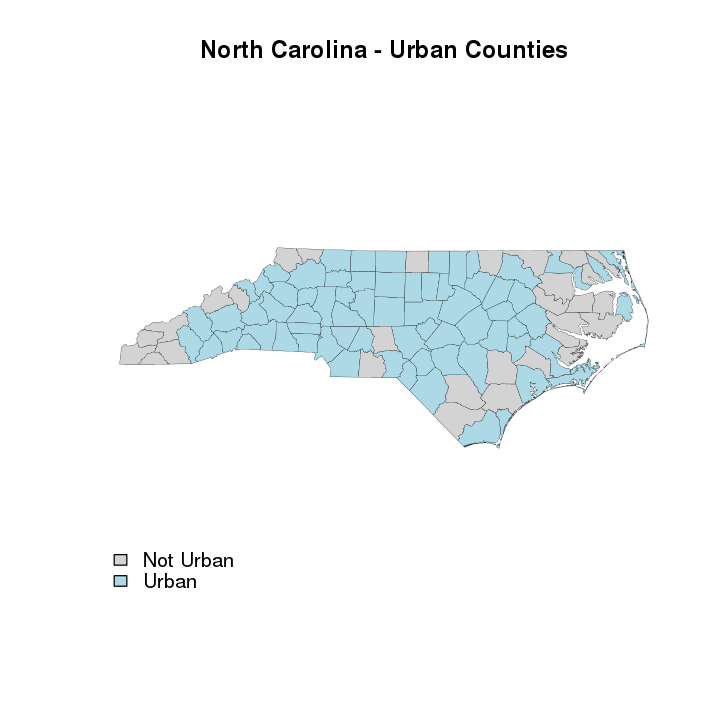

In [35]:
# Plotting Response Variable
# Urban or Not

pal <- c("lightgray", "lightblue")
cols <- pal[round(joined@data$urban) + 1]

plot(joined, col = cols, lwd = 0.2, main = "North Carolina - Urban Counties")
leg <- c("Not Urban", "Urban")
legend("bottomleft", fill = pal, legend = leg, bty = "n")

Map the geographic distribution of the explanatory variable as classified into 5 quantiles. 

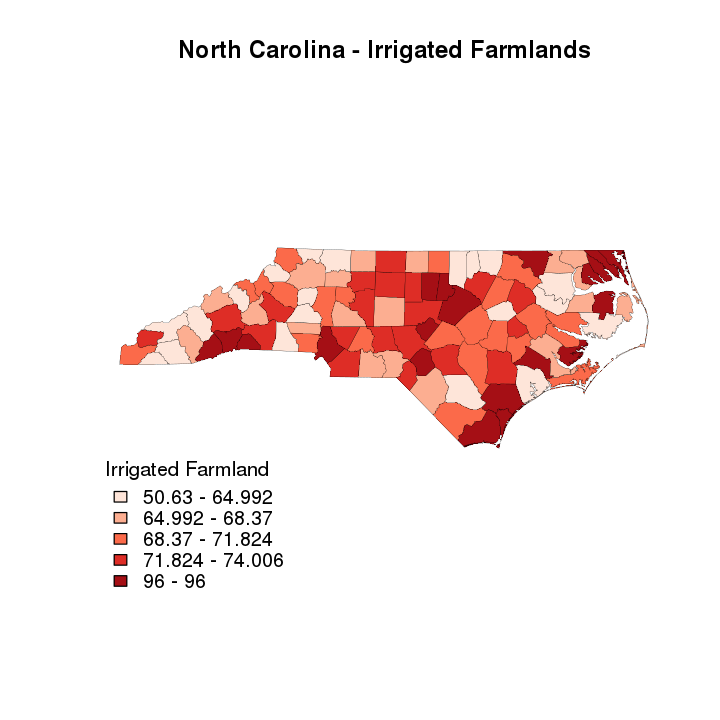

In [36]:
# Plotting Explanatory Variable
# y12_M247_1
# acres of irrigated land as percent of land in farms acreage

numcat <- 5
cate <- classIntervals(Ex_Var, numcat, style = "quantile")

pal <- brewer.pal(numcat, "Reds")
cols <- findColours(cate, pal)

plot(joined, col = cols, 
         lwd = 0.2, main = "North Carolina - Irrigated Farmlands")

brks <- round(cate$brks, 3)

leg <- paste(brks[-numcat], brks[-1], sep = " - ")

legend("bottomleft", fill = pal, legend = leg, 
       bty = "n", title = "Irrigated Farmland")

Test for autocorrelation in the dependant variable. 

In [37]:
# Y_Var autocorrelation

moran.test(Y_Var, joined.nb.listb)


	Moran I test under randomisation

data:  Y_Var  
weights: joined.nb.listb  

Moran I statistic standard deviate = 4.6908, p-value = 1.36e-06
alternative hypothesis: greater
sample estimates:
Moran I statistic       Expectation          Variance 
       0.28197758       -0.01010101        0.00387702 


<b style="color:red;">JACKY:</b>

* H0 = Variable is randomly distributed. There is no signs of autocorrelation.
* H1 = Variable is not randomly distributed. There are signs of autocorrelation. 

<b style="color:red;">RESULTS:</b>

* P-Value = 1.36e-6
* Alpha Value (95% confidence) = 0.05
* P-Value < Alpha Value so we reject the null hypothesis. There does seem to be signs of autocorrelation in response variable, Y_Var.

Apply a standard binomial logistic regression. 

Test the residuals for spatial autocorrelation. 

Establish a threshold for what qualifies as significant spatial autocorrelation. 

In [38]:
binom.lm <- glm(Y_Var ~ Ex_Var, family = binomial)
summary(binom.lm)


Call:
glm(formula = Y_Var ~ Ex_Var, family = binomial)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.9141  -1.3474   0.7716   0.8501   1.0910  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)
(Intercept) -2.56285    2.24540  -1.141    0.254
Ex_Var       0.04965    0.03232   1.536    0.124

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 120.43  on 99  degrees of freedom
Residual deviance: 117.92  on 98  degrees of freedom
AIC: 121.92

Number of Fisher Scoring iterations: 4


In [39]:
binom.lm.resid <- residuals(binom.lm)

In [40]:
moran.test(binom.lm.resid, joined.nb.listb)


	Moran I test under randomisation

data:  binom.lm.resid  
weights: joined.nb.listb  

Moran I statistic standard deviate = 4.4033, p-value = 5.331e-06
alternative hypothesis: greater
sample estimates:
Moran I statistic       Expectation          Variance 
      0.263954323      -0.010101010       0.003873681 


<b style="color:red;">JACKY:</b>

* H0 = Residuals are randomly distributed. No signs of autocorrelation.
* H1 = Residuals are not randomly distributed. Signs of autocorrelation.

<b style="color:red;">RESULTS:</b>

* P-Value = 5.33e-6
* Alpha Value = 0.05 (95% confidence)
* P-Value < Alpha Value so we reject the null hypothesis. The residuals seems to have signs of autocorrelation. 

Compute the MBM matrix.

In [41]:
#compute MBM
n <- length(joined)
M <- diag(n) - matrix(1, n, n) / n
B <- listw2mat(joined.nb.listb)

MBM <- M %*% B %*% M

head(MBM)

-0.071,0.959,-0.041,-0.041,-0.041,-0.031,-0.041,0.949,0.949,-0.061,⋯,-0.041,-0.031,-0.071,-0.031,-0.051,-0.071,-0.031,-0.041,-0.031,-0.061
0.959,-0.011,-0.011,-0.011,-0.011,-0.001,-0.011,-0.021,-0.021,-0.031,⋯,-0.011,-0.001,-0.041,-0.001,-0.021,-0.041,-0.001,-0.011,-0.001,-0.031
-0.041,-0.011,-0.011,0.989,-0.011,-0.001,-0.011,-0.021,-0.021,-0.031,⋯,-0.011,-0.001,-0.041,-0.001,-0.021,-0.041,-0.001,-0.011,-0.001,-0.031
-0.041,-0.011,0.989,-0.011,-0.011,-0.001,-0.011,-0.021,-0.021,-0.031,⋯,-0.011,-0.001,-0.041,-0.001,-0.021,-0.041,-0.001,-0.011,-0.001,-0.031
-0.041,-0.011,-0.011,-0.011,-0.011,0.999,0.989,-0.021,-0.021,0.969,⋯,-0.011,-0.001,-0.041,-0.001,-0.021,-0.041,-0.001,-0.011,-0.001,-0.031
-0.031,-0.001,-0.001,-0.001,0.999,0.009,-0.001,-0.011,-0.011,0.979,⋯,-0.001,0.009,-0.031,0.009,-0.011,-0.031,0.009,-0.001,0.009,-0.021


Extract the eigenvectors. 

In [42]:
eig <- eigen(MBM, symmetric = T)

In [43]:
names(eig)

[1] "values"  "vectors"

In [44]:
print("First 5 values of Eigenvalues:")
print(eig$values[1:5])

[1] "First 5 values of Eigenvalues:"
[1] 5.568772 5.325745 4.788322 4.680486 4.433713


In [45]:
print("First 5 values of Eigenvectors:")
(eig$vectors[1:5, ])

[1] "First 5 values of Eigenvectors:"


0.027348541,0.11464845,-0.19540001,-0.107873291,-0.18552813,-0.024566668,-0.16068864,-0.08611670,0.01951172,-0.150410528,⋯,0.093071483,-0.092064123,0.037389761,0.08385536,-0.18177240,-0.13783086,-0.0004674771,0.014680845,0.046129819,2.822431e-03
0.020081411,0.07742495,-0.12440822,-0.070028870,-0.10003108,-0.017292561,-0.07928763,-0.01235754,0.06597025,-0.009680691,⋯,-0.124264212,0.002992426,-0.021175177,-0.02745851,0.03996829,0.01835979,0.0047630839,-0.008634840,-0.022193092,-7.020578e-04
0.061033055,0.03999348,0.05277150,0.005200497,0.06823284,0.083765664,0.04746991,-0.10195144,0.07225339,-0.136342500,⋯,0.006474126,0.046595376,0.069244258,0.07437229,0.06280562,0.02218424,0.0326826777,-0.039564148,-0.051242775,1.304228e-02
0.055981079,0.05112283,0.03528484,0.002262343,0.08749467,0.059492844,0.06956721,-0.07335512,0.05797289,-0.143248522,⋯,-0.097071349,-0.067077324,-0.038974912,-0.02435994,-0.08546231,-0.07782131,0.0010932902,0.001460506,-0.085163928,-1.508983e-02
0.003160252,0.02632167,-0.03404189,-0.011407055,-0.05664721,0.007435625,-0.01938111,-0.09629411,-0.13331821,-0.166910100,⋯,-0.012489930,0.010088227,-0.007518518,-0.01222869,0.02357383,0.01703299,0.0006483379,-0.003437736,-0.005949284,1.454505e-05


In [46]:
paste("Number of Eigenvalues generated: ", length(eig$values))

[1] "Number of Eigenvalues generated:  100"

In [47]:
paste("Number of Eigenvectors generated: ", nrow(eig$vectors))

[1] "Number of Eigenvectors generated:  100"

Select the eigenvectors that are associated with eigenvalues that are within 23% of the highest eigenvalue. 

In [48]:
cutThreshold <- 0.23
EV <- as.data.frame(eig$vectors[, eig$values / eig$values[1] > cutThreshold])

In [49]:
colnames(EV) <- paste("EV", 1:ncol(EV), sep = "")

In [50]:
paste("Number of Eigenvectors retained: ", ncol(EV))

[1] "Number of Eigenvectors retained:  25"

In [51]:
head(EV)

EV1,EV2,EV3,EV4,EV5,EV6,EV7,EV8,EV9,EV10,⋯,EV16,EV17,EV18,EV19,EV20,EV21,EV22,EV23,EV24,EV25
0.027348541,0.11464845,-0.19540001,-0.107873291,-0.18552813,-0.024566668,-0.16068864,-0.08611670,0.01951172,-0.150410528,⋯,-0.15003843,-0.005946204,-0.1073186452,0.084824260,-0.14820562,0.0057993601,0.17374206,-0.01756726,-0.10641373,-0.04289477
0.020081411,0.07742495,-0.12440822,-0.070028870,-0.10003108,-0.017292561,-0.07928763,-0.01235754,0.06597025,-0.009680691,⋯,-0.03982131,0.071348611,0.1119365567,-0.004800103,-0.16254409,0.1616544427,0.08820745,-0.05526388,0.01044839,0.17193343
0.061033055,0.03999348,0.05277150,0.005200497,0.06823284,0.083765664,0.04746991,-0.10195144,0.07225339,-0.136342500,⋯,-0.02653686,-0.204947037,0.0454476204,-0.181458893,0.10104873,0.0135831867,-0.03865054,-0.15578962,-0.09867647,0.11340265
0.055981079,0.05112283,0.03528484,0.002262343,0.08749467,0.059492844,0.06956721,-0.07335512,0.05797289,-0.143248522,⋯,-0.07650989,-0.183958470,-0.0002296368,-0.136852221,0.03069994,-0.0447066942,-0.09013901,-0.24202954,-0.16294865,0.09677325
0.003160252,0.02632167,-0.03404189,-0.011407055,-0.05664721,0.007435625,-0.01938111,-0.09629411,-0.13331821,-0.166910100,⋯,0.10651559,0.039391682,0.0990315746,-0.070321090,0.12422158,-0.0029030361,-0.18581989,0.02377707,0.15764587,0.12928766
0.002507703,0.02128706,-0.02617149,-0.008263289,-0.04368940,0.006302743,-0.01234875,-0.07391150,-0.10336736,-0.123937283,⋯,0.08431158,0.027494065,0.0779044515,-0.056884304,0.09898094,0.0004453425,-0.15853781,0.01766011,0.13868539,0.10827702


Use step-wise regression to further refine the set of eigenvectors that will be used to develop a spatial filter. 

Limit the number of eigenvectors selected to the 6 most relevant ones.

In [52]:
binom.lm2 <- glm(Y_Var ~ Ex_Var + ., 
                    data = EV, 
                    family = binomial)

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”

In [55]:
binom.sf <- stepAIC(glm(Y_Var ~ Ex_Var, data = EV, family = binomial),
                       scope = list(upper = binom.lm2),
                       direction = "both", 
                       k = 2)

coefnm <- names(coef(binom.sf))

coefm

Start:  AIC=121.92
Y_Var ~ Ex_Var

         Df Deviance    AIC
+ EV25    1   108.79 114.79
+ EV8     1   109.78 115.78
+ EV9     1   110.42 116.42
+ EV5     1   110.82 116.82
+ EV7     1   113.29 119.29
+ EV14    1   114.77 120.77
+ EV4     1   114.81 120.81
+ EV15    1   115.50 121.50
+ EV1     1   115.85 121.85
<none>        117.92 121.92
- Ex_Var  1   120.43 122.43
+ EV13    1   116.96 122.96
+ EV2     1   117.01 123.01
+ EV18    1   117.13 123.13
+ EV12    1   117.14 123.14
+ EV22    1   117.27 123.27
+ EV17    1   117.34 123.34
+ EV11    1   117.45 123.45
+ EV23    1   117.46 123.46
+ EV20    1   117.70 123.70
+ EV19    1   117.75 123.75
+ EV3     1   117.77 123.77
+ EV21    1   117.83 123.83
+ EV24    1   117.84 123.84
+ EV6     1   117.84 123.84
+ EV10    1   117.90 123.90
+ EV16    1   117.92 123.92

Step:  AIC=114.79
Y_Var ~ Ex_Var + EV25

         Df Deviance    AIC
+ EV8     1   99.006 107.01
+ EV5     1  101.642 109.64
+ EV9     1  101.918 109.92
+ EV7     1  104.485 112.48


Step:  AIC=74.96
Y_Var ~ EV25 + EV8 + EV5 + EV9 + EV4 + EV12 + EV7 + EV23 + EV18

         Df Deviance    AIC
+ EV17    1   52.398 74.398
<none>        54.955 74.955
+ EV22    1   53.390 75.390
+ EV21    1   53.481 75.481
+ EV14    1   53.562 75.562
+ EV13    1   53.657 75.657
+ Ex_Var  1   54.352 76.352
+ EV11    1   54.413 76.413
+ EV1     1   54.707 76.707
+ EV3     1   54.838 76.838
+ EV10    1   54.871 76.871
+ EV15    1   54.876 76.876
+ EV16    1   54.891 76.891
+ EV19    1   54.916 76.916
+ EV2     1   54.927 76.927
+ EV6     1   54.932 76.932
+ EV20    1   54.940 76.940
+ EV24    1   54.955 76.955
- EV7     1   59.427 77.427
- EV18    1   60.446 78.446
- EV23    1   60.504 78.504
- EV12    1   62.930 80.930
- EV4     1   65.976 83.976
- EV9     1   69.360 87.360
- EV25    1   71.793 89.793
- EV5     1   76.836 94.836
- EV8     1   79.166 97.166

Step:  AIC=74.4
Y_Var ~ EV25 + EV8 + EV5 + EV9 + EV4 + EV12 + EV7 + EV23 + EV18 + 
    EV17

         Df Deviance    AIC
+ EV22    1

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”

         Df Deviance     AIC
<none>        46.251  72.251
+ EV14    1   44.270  72.270
+ Ex_Var  1   45.182  73.182
- EV21    1   49.458  73.458
+ EV15    1   45.809  73.809
+ EV16    1   45.838  73.838
+ EV1     1   45.891  73.891
+ EV6     1   45.976  73.976
+ EV11    1   46.029  74.029
+ EV19    1   46.157  74.157
+ EV24    1   46.165  74.165
+ EV13    1   46.186  74.186
+ EV10    1   46.190  74.190
+ EV2     1   46.195  74.195
+ EV3     1   46.240  74.240
+ EV20    1   46.251  74.251
- EV22    1   50.899  74.899
- EV17    1   51.058  75.058
- EV7     1   52.069  76.069
- EV18    1   53.140  77.140
- EV12    1   53.458  77.458
- EV23    1   56.513  80.513
- EV4     1   62.590  86.590
- EV9     1   62.989  86.989
- EV25    1   69.306  93.306
- EV5     1   75.715  99.715
- EV8     1   77.795 101.795


ERROR: Error in eval(expr, envir, enclos): object 'coefm' not found


In [56]:
formula2 <- c(Y_Var ~ Ex_Var)
exComp <- 6
ctit <- 1
formlist <- list()
formula3 <- c()
incnt <- 1

for (ele in coefnm){
    if ((ctit <= exComp) && (startsWith(ele, "EV"))){
        formula2 <- paste(formula2, "+", sep = " ")
        formula2 <- paste(formula2, ele, sep = " ")
        s1 <- unlist(strsplit(ele, split = "EV", fixed = TRUE))[2]
        formlist[[ctit]] <- as.numeric(s1)
        
        ctit <- ctit + 1
    }
    
    incnt <- incnt + 1
}

In [66]:
paste("Eigenvectors selected: ")
formlist

[1] "Eigenvectors selected: "

[[1]]
[1] 25

[[2]]
[1] 8

[[3]]
[1] 5

[[4]]
[1] 9

[[5]]
[1] 4

[[6]]
[1] 12

In [67]:
paste("Formula: ", formula2)

[1] "Formula:  Y_Var ~ Ex_Var + EV25 + EV8 + EV5 + EV9 + EV4 + EV12"

Populate a non-linear binomial regression with the response and explanatory variables (including the spatial filter - the selected eigenvectors). 

Test the model residuals (make sure they are rounded 'response' residuals) for spatial autocorrelation.

In [68]:
Y_Var_sf <- glm(formula2, data= EV, family = binomial)
summary(Y_Var_sf)


Call:
glm(formula = formula2, family = binomial, data = EV)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.9996  -0.3413   0.1341   0.4880   2.1250  

Coefficients:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept)   1.868925   2.859404   0.654 0.513365    
Ex_Var        0.003879   0.039091   0.099 0.920958    
EV25        -15.203771   4.726365  -3.217 0.001296 ** 
EV8          16.484571   4.865246   3.388 0.000703 ***
EV5          14.460257   4.499128   3.214 0.001309 ** 
EV9          10.640618   3.825066   2.782 0.005406 ** 
EV4          -7.403346   3.301437  -2.242 0.024932 *  
EV12          7.716001   4.001676   1.928 0.053831 .  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 120.430  on 99  degrees of freedom
Residual deviance:  69.082  on 92  degrees of freedom
AIC: 85.082

Number of Fisher Scoring iterations: 6


In [69]:
Y_Var_sf_res <- residuals(Y_Var_sf, type = "response")
Y_Var_sf_res <- round(Y_Var_sf_res)

In [72]:
moran.test(Y_Var_sf_res, joined.nb.listb)


	Moran I test under randomisation

data:  Y_Var_sf_res  
weights: joined.nb.listb  

Moran I statistic standard deviate = -0.011638, p-value = 0.5046
alternative hypothesis: greater
sample estimates:
Moran I statistic       Expectation          Variance 
     -0.010804322      -0.010101010       0.003652217 


<b style="color:red;">JACKY:</b>

* H0 = Residuals are randomly distributed with no signs of autocorrelation.
* H1 = Residuals are NOT randomly distributed. Shows signs of autocorrelation.

<b style="color:red;">RESULTS:</b>

* P-Value = 0.50
* Alpha Value = 0.05 (95% confidence)
* P-Value > Alpha Value so we fail to reject the null hypothesis. There appears to be no signs of autocorrelation using the Moran I Test.


Plot the fitted values obtained via the spatially filtered logistic model. Classify the fitted values into 4 quantiles.

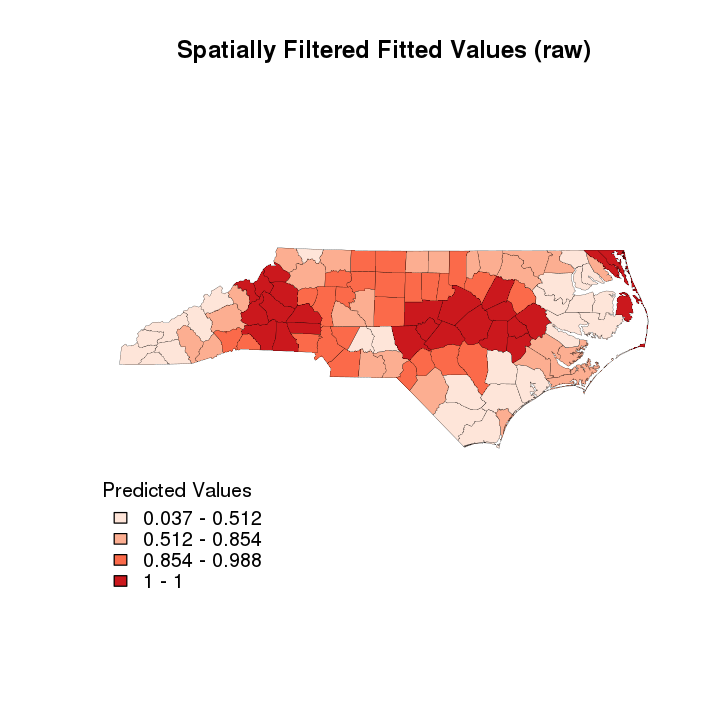

In [75]:
numcat <- 4

cate <- classIntervals(Y_Var_sf$fitted, numcat, style = "quantile")

pal <- brewer.pal(numcat, "Reds")

cols <- findColours(cate, pal)

plot(joined, col = cols, lwd = 0.2, 
         main = "Spatially Filtered Fitted Values (raw)")

brks <- round(cate$brks, 3)

leg <- paste(brks[-numcat], brks[-1], sep = " - ")

legend("bottomleft", fill = pal, 
           legend = leg, bty = "n", title = "Predicted Values")

Round the fitted values so they are either 0 or 1 values. 

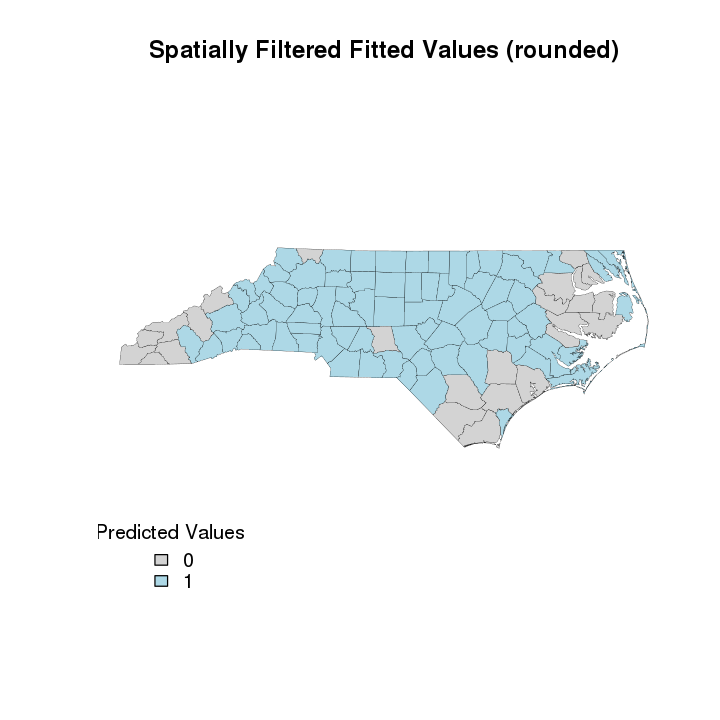

In [81]:
pal <- c("lightgray", "lightblue")
cols <- pal[round(Y_Var_sf$fitted) + 1]

plot(joined, col = cols, lwd = 0.2, 
     main = "Spatially Filtered Fitted Values (rounded)")

leg <- c("0", "1")

legend("bottomleft", fill = pal, legend = leg, bty = "n", 
          title = "Predicted Values")